In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


## 1. Data Loading

In [25]:
gen_df = pd.read_csv('Plant_1_Generation_Data.csv')
weath_df = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

In [27]:
# Overview data generation
gen_df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [28]:
# Overview data weather

weath_df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [29]:
print(gen_df['SOURCE_KEY'].unique().size)
print(weath_df['SOURCE_KEY'].unique().size)

print(gen_df['PLANT_ID'].unique().size)
print(gen_df['PLANT_ID'].unique().size)

22
1
1
1


In [30]:
gen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


 Format datetime columns and merge Data Frames


In [31]:
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'])
weath_df['DATE_TIME'] = pd.to_datetime(weath_df['DATE_TIME'])

In [32]:
power_df = pd.merge(gen_df.drop(columns=['PLANT_ID']),weath_df.drop(columns=['PLANT_ID','SOURCE_KEY']), on='DATE_TIME')

In [33]:
power_df.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0
2,2020-05-15,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0
3,2020-05-15,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0
4,2020-05-15,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0


Seperating date time to further analysis

In [34]:
power_df['DATE'] = pd.to_datetime(power_df["DATE_TIME"]).dt.date
power_df['TIME'] = pd.to_datetime(power_df["DATE_TIME"]).dt.time
power_df['DAY'] = pd.to_datetime(power_df["DATE_TIME"]).dt.day
power_df['MONTH'] = pd.to_datetime(power_df["DATE_TIME"]).dt.month
power_df['WEEK'] = pd.to_datetime(power_df["DATE_TIME"]).dt.week

C:\Users\USER\AppData\Local\Temp\ipykernel_9280\3949707645.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  power_df['WEEK'] = pd.to_datetime(power_df["DATE_TIME"]).dt.week


In [35]:
#add hours and minutes for ml models

power_df['HOURS'] = pd.to_datetime(power_df['TIME'],format='%H:%M:%S').dt.hour
power_df['MINUTES'] = pd.to_datetime(power_df['TIME'],format='%H:%M:%S').dt.minute
power_df['TOTAL MINUTES PASS'] =power_df['MINUTES'] + power_df['HOURS'] *60

In [36]:
#add date as string column
power_df["DATE_STRING"] = power_df["DATE"].astype(str) 
power_df["HOURS"] = power_df["HOURS"].astype(str)
power_df["TIME"] = power_df["TIME"].astype(str)

In [37]:
power_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45680 entries, 0 to 45679
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            45680 non-null  datetime64[ns]
 1   SOURCE_KEY           45680 non-null  object        
 2   DC_POWER             45680 non-null  float64       
 3   AC_POWER             45680 non-null  float64       
 4   DAILY_YIELD          45680 non-null  float64       
 5   TOTAL_YIELD          45680 non-null  float64       
 6   AMBIENT_TEMPERATURE  45680 non-null  float64       
 7   MODULE_TEMPERATURE   45680 non-null  float64       
 8   IRRADIATION          45680 non-null  float64       
 9   DATE                 45680 non-null  object        
 10  TIME                 45680 non-null  object        
 11  DAY                  45680 non-null  int64         
 12  MONTH                45680 non-null  int64         
 13  WEEK                 45680 non-

In [38]:
power_df.head(2)

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,TOTAL MINUTES PASS,DATE_STRING
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15
1,2020-05-15,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0,2020-05-15,00:00:00,15,5,20,0,0,0,2020-05-15


## 2. Cleaning Data

In [39]:
power_df.isnull().sum()

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
DATE                   0
TIME                   0
DAY                    0
MONTH                  0
WEEK                   0
HOURS                  0
MINUTES                0
TOTAL MINUTES PASS     0
DATE_STRING            0
dtype: int64

In [40]:
power_df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
45675    False
45676    False
45677    False
45678    False
45679    False
Length: 45680, dtype: bool

In [41]:
power_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DC_POWER,45680.0,3.197176e+03,4080.448523,0.000000e+00,0.000000e+00,4.641964e+02,6.478424e+03,1.447112e+04
AC_POWER,45680.0,3.126527e+02,398.668968,0.000000e+00,0.000000e+00,4.491250e+01,6.344813e+02,1.410950e+03
DAILY_YIELD,45680.0,3.313147e+03,3156.100252,0.000000e+00,0.000000e+00,2.653634e+03,6.318000e+03,9.163000e+03
TOTAL_YIELD,45680.0,6.957007e+06,417238.643557,6.183645e+06,6.512358e+06,7.115711e+06,7.244521e+06,7.846821e+06
AMBIENT_TEMPERATURE,45680.0,2.591717e+01,3.556550,2.039850e+01,2.293003e+01,2.499302e+01,2.837901e+01,3.525249e+01
MODULE_TEMPERATURE,45680.0,3.187797e+01,12.638448,1.814042e+01,2.140639e+01,2.537907e+01,4.275712e+01,6.554571e+01
IRRADIATION,45680.0,2.368335e-01,0.306316,0.000000e+00,0.000000e+00,3.526559e-02,4.595030e-01,1.221652e+00
DAY,45680.0,2.041432e+01,6.258661,6.000000e+00,1.600000e+01,2.000000e+01,2.600000e+01,3.100000e+01
MONTH,45680.0,5.275131e+00,0.446585,5.000000e+00,5.000000e+00,5.000000e+00,6.000000e+00,6.000000e+00
WEEK,45680.0,2.209054e+01,1.568935,2.000000e+01,2.100000e+01,2.200000e+01,2.300000e+01,2.500000e+01


In [42]:
power_df.count()

DATE_TIME              45680
SOURCE_KEY             45680
DC_POWER               45680
AC_POWER               45680
DAILY_YIELD            45680
TOTAL_YIELD            45680
AMBIENT_TEMPERATURE    45680
MODULE_TEMPERATURE     45680
IRRADIATION            45680
DATE                   45680
TIME                   45680
DAY                    45680
MONTH                  45680
WEEK                   45680
HOURS                  45680
MINUTES                45680
TOTAL MINUTES PASS     45680
DATE_STRING            45680
dtype: int64

 Check for correlation of input fields

In [43]:
corr = power_df.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\USER\AppData\Local\Temp\ipykernel_9280\2031501973.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = power_df.corr()


,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,WEEK,MINUTES,TOTAL MINUTES PASS
DC_POWER,1.000000,0.999996,0.076710,0.004055,0.703796,0.954692,0.991305,0.049284,-0.042781,-0.029993,-0.000089,0.012161
AC_POWER,0.999996,1.000000,0.076628,0.004043,0.704035,0.954810,0.991260,0.049162,-0.042688,-0.029943,-0.000099,0.012131
DAILY_YIELD,0.076710,0.076628,1.000000,0.007277,0.489709,0.203702,0.071937,0.030742,-0.012850,-0.008640,0.015915,0.823653
TOTAL_YIELD,0.004055,0.004043,0.007277,1.000000,-0.036532,-0.014713,-0.004981,-0.053243,0.167196,0.182590,0.000088,0.005257
AMBIENT_TEMPERATURE,0.703796,0.704035,0.489709,-0.036532,1.000000,0.843456,0.702218,0.164977,-0.237136,-0.214439,-0.000860,0.322871
MODULE_TEMPERATURE,0.954692,0.954810,0.203702,-0.014713,0.843456,1.000000,0.959346,0.105859,-0.116531,-0.092254,-0.003603,0.103610
IRRADIATION,0.991305,0.991260,0.071937,-0.004981,0.702218,0.959346,1.000000,0.056562,-0.051316,-0.037322,-0.001372,0.009203
DAY,0.049284,0.049162,0.030742,-0.053243,0.164977,0.105859,0.056562,1.000000,-0.678315,-0.282778,-0.001047,0.015635
MONTH,-0.042781,-0.042688,-0.012850,0.167196,-0.237136,-0.116531,-0.051316,-0.678315,1.000000,0.882285,0.000818,-0.012040
WEEK,-0.029993,-0.029943,-0.008640,0.182590,-0.214439,-0.092254,-0.037322,-0.282778,0.882285,1.000000,0.000426,-0.008505


 Convert 'Source_Key' to numerical type

In [44]:

encoder = LabelEncoder()

power_df['SOURCE_KEY'] = encoder.fit_transform(power_df['SOURCE_KEY'])

power_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45680 entries, 0 to 45679
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            45680 non-null  datetime64[ns]
 1   SOURCE_KEY           45680 non-null  int32         
 2   DC_POWER             45680 non-null  float64       
 3   AC_POWER             45680 non-null  float64       
 4   DAILY_YIELD          45680 non-null  float64       
 5   TOTAL_YIELD          45680 non-null  float64       
 6   AMBIENT_TEMPERATURE  45680 non-null  float64       
 7   MODULE_TEMPERATURE   45680 non-null  float64       
 8   IRRADIATION          45680 non-null  float64       
 9   DATE                 45680 non-null  object        
 10  TIME                 45680 non-null  object        
 11  DAY                  45680 non-null  int64         
 12  MONTH                45680 non-null  int64         
 13  WEEK                 45680 non-

## Data Visualization for analysis on solar power generated


In [45]:
power_df['DATE'].nunique()

23

#### 1. The data of solar power generation is of 23 days 
#### 2. Faults & Abnormalities can be detected in solar power plant generation 
#### 3. Plotting of DC power generation on per day basis

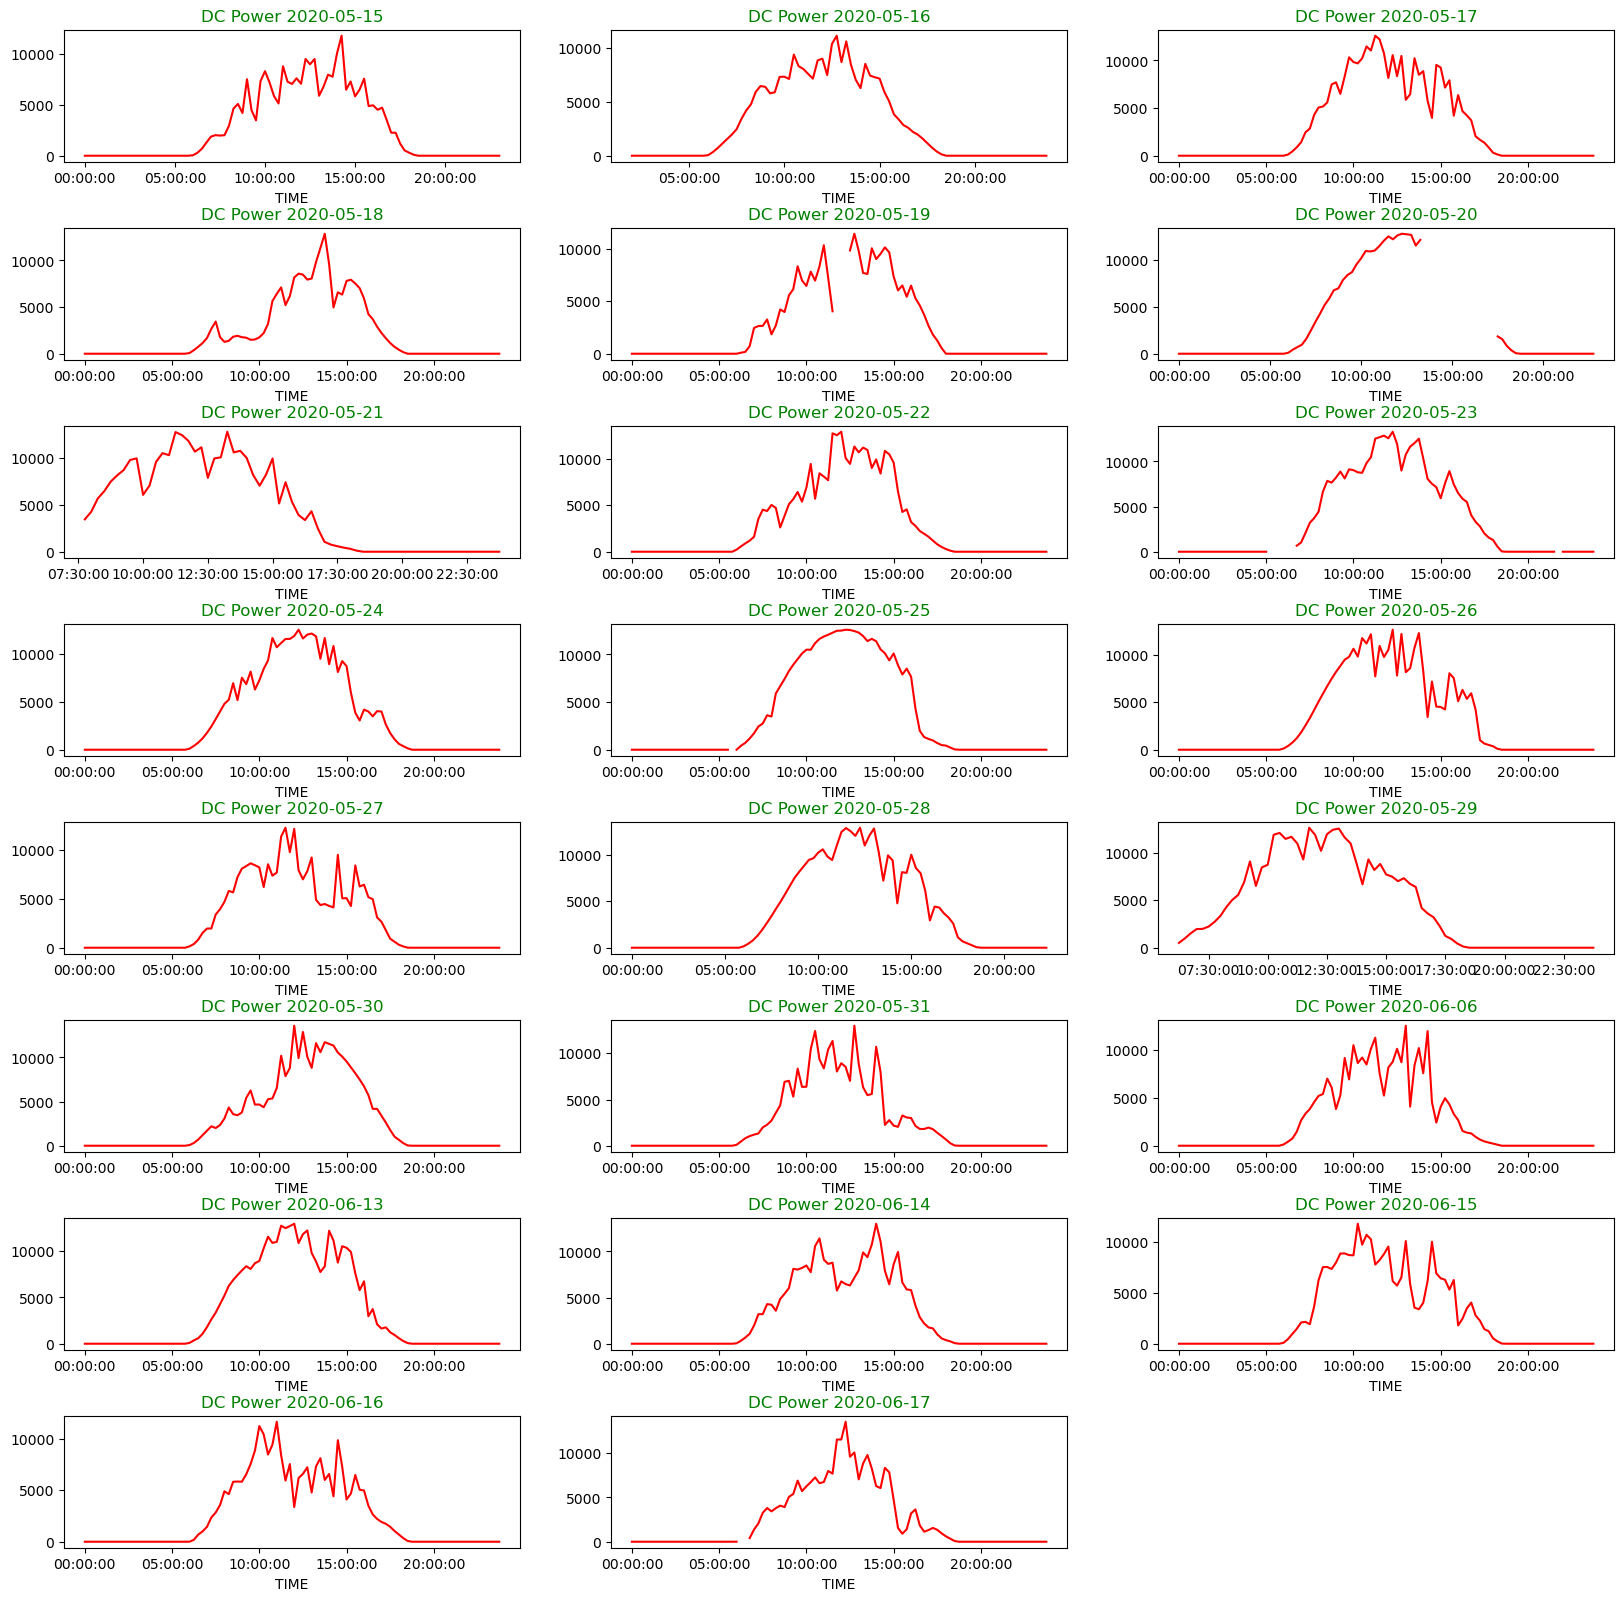

In [46]:
power_dc = power_df.pivot_table(values='DC_POWER', index = 'TIME', columns = 'DATE')

def Daywise_plot(data=None, row = None, col = None, title='DC Power'):
    cols = data.columns
    gp = plt.figure(figsize=(20,30))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax=gp.add_subplot(row,col,i)
        data[cols[i-1]].plot(ax=ax, color='red')
        ax.set_title('{} {}'.format(title,cols[i-1]),color='green')

Daywise_plot(data=power_dc, row=12,col=3)

According to graph shows the DC_POWER generation, there is a some fluctuation in the solar power generation.

Less Fluctuation in DC_POWER generation is observed in the below mentioned days

    2020-05-15
    2020-05-18
    2020-05-22
    2020-05-23
    2020-05-24
    2020-05-25
    2020-05-26

High Fluctuation in DC_POWER is observed in the below mentioned days

    2020-05-19
    2020-05-28
    2020-05-29
    2020-06-02
    2020-06-03
    2020-06-04
    2020-06-13
    2020-06-14
    2020-06-17

Very High Fluctuation & Reduction in DC_POWER generation is observed in in the below mentioned days.

    2020-06-03
    2020-06-11
    2020-06-12
    2020-06-15

Note: Reason for very high Fluctuation & Reduction in DC_POWER generation is due to fault in the system or may be fluctuation in weather or due to clouds etc. which need to be analyse further.


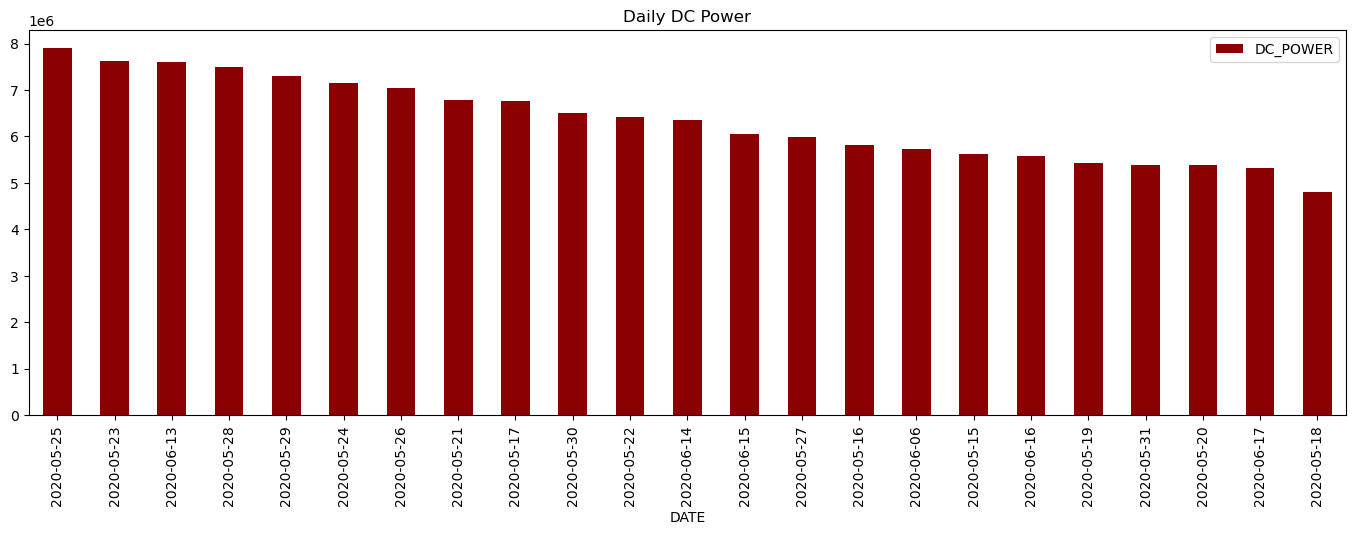

In [47]:
daily_dc = power_df.groupby('DATE')['DC_POWER'].agg('sum')

ax = daily_dc.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='darkred')
plt.title('Daily DC Power')
plt.show()

4. Plotting Irradation generation per daily basis

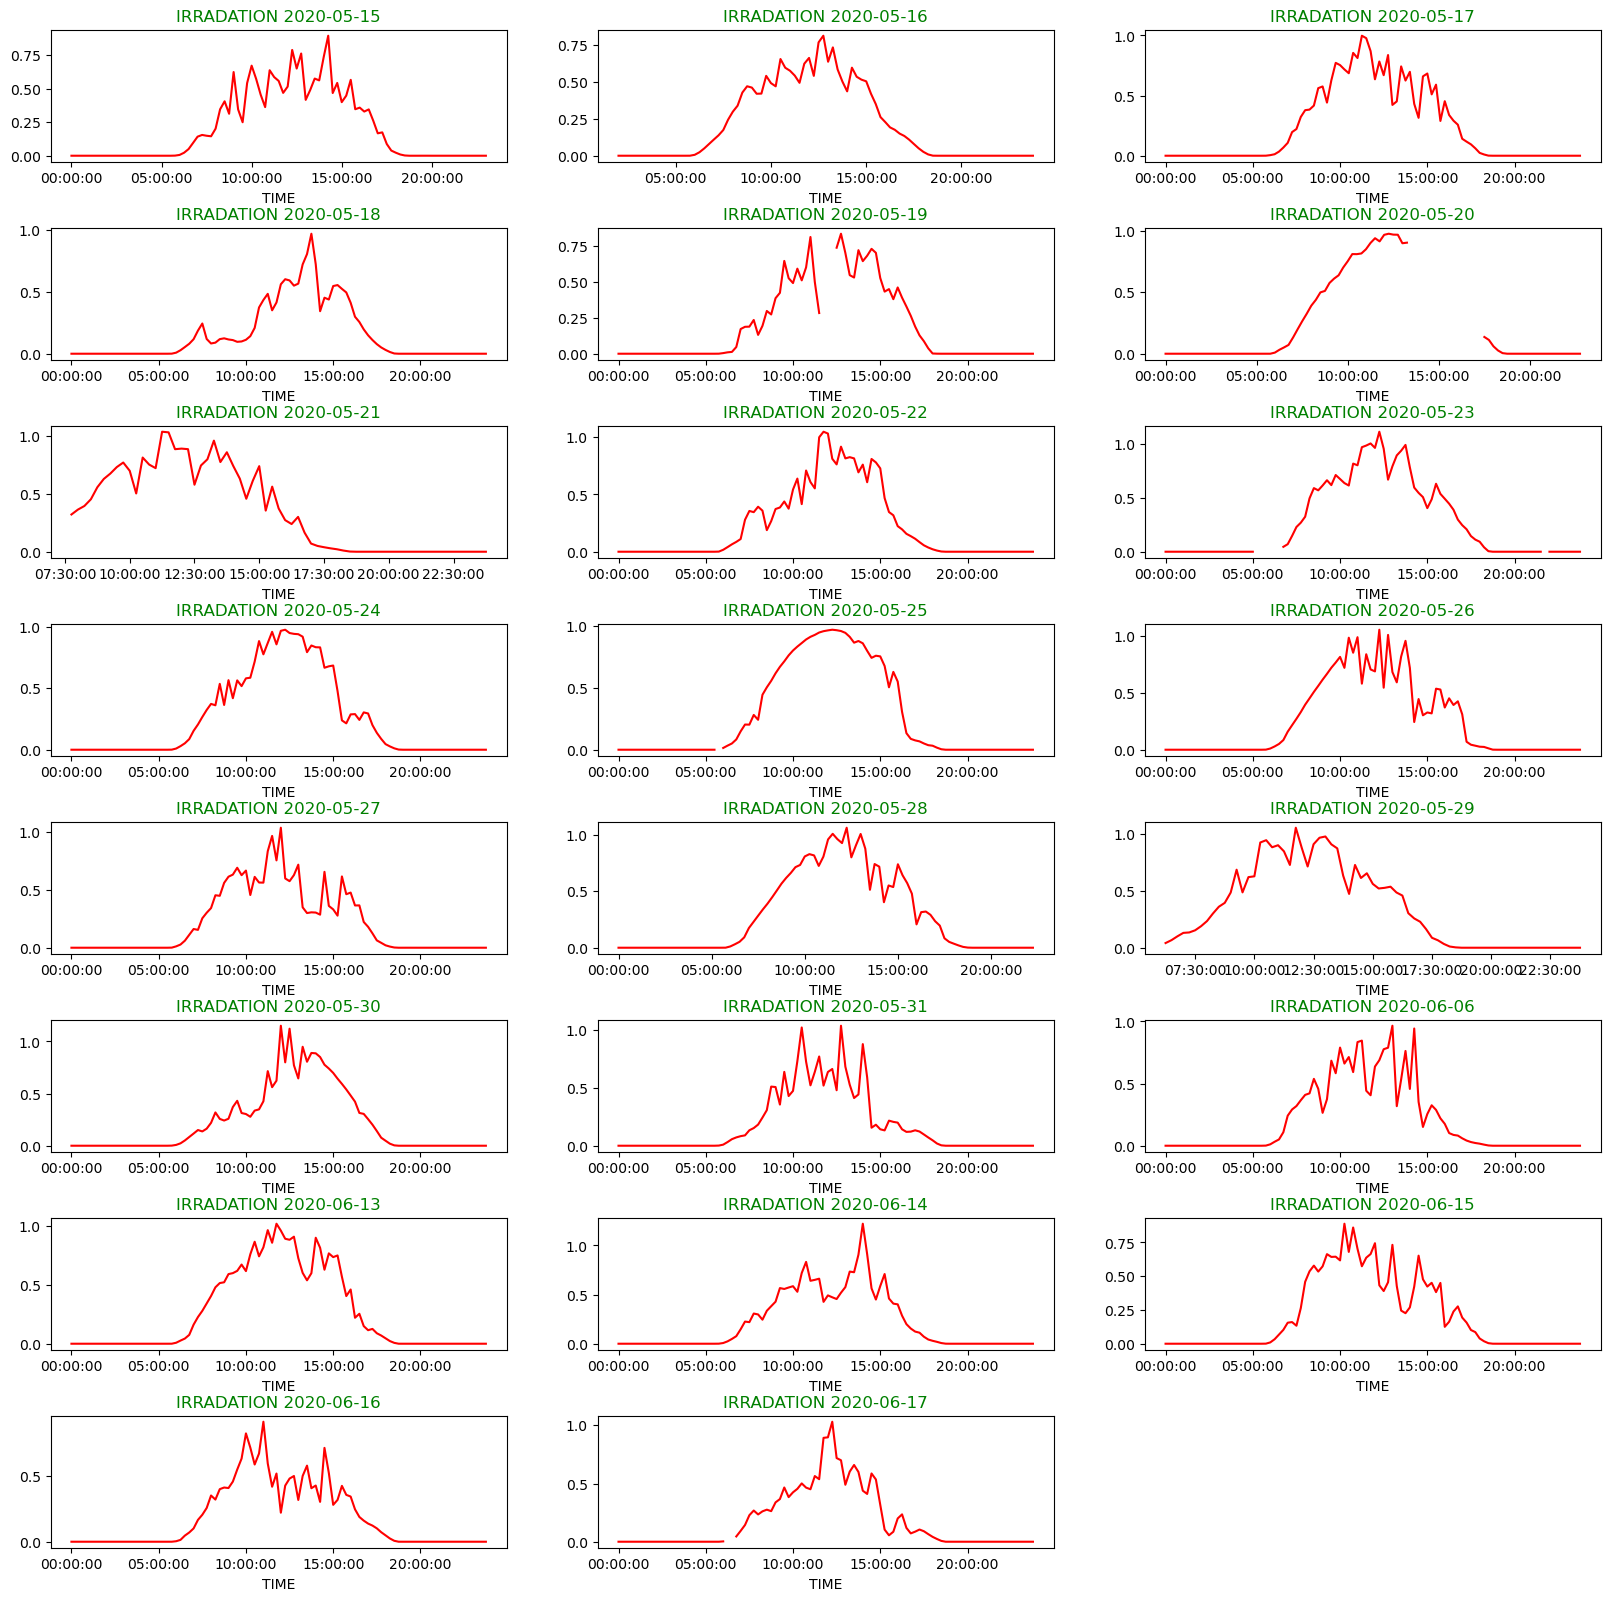

In [48]:
power_irr = power_df.pivot_table(values='IRRADIATION', index = 'TIME', columns = 'DATE')

def Daywise_plot(data=None, row = None, col = None, title='IRRADATION'):
    cols = data.columns
    gp = plt.figure(figsize=(20,30))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax=gp.add_subplot(row,col,i)
        data[cols[i-1]].plot(ax=ax, color='red')
        ax.set_title('{} {}'.format(title,cols[i-1]),color='green')

Daywise_plot(data=power_irr, row=12,col=3)

Theorically, the DC_POWER or output power mostly depends on the the IRRADATION received from the sun. Technically, we can conclude as the Generation is directly propotional to IRRADATION. Hence, the graph pattern between DC_POWER with IRRADATION are looking very similar.

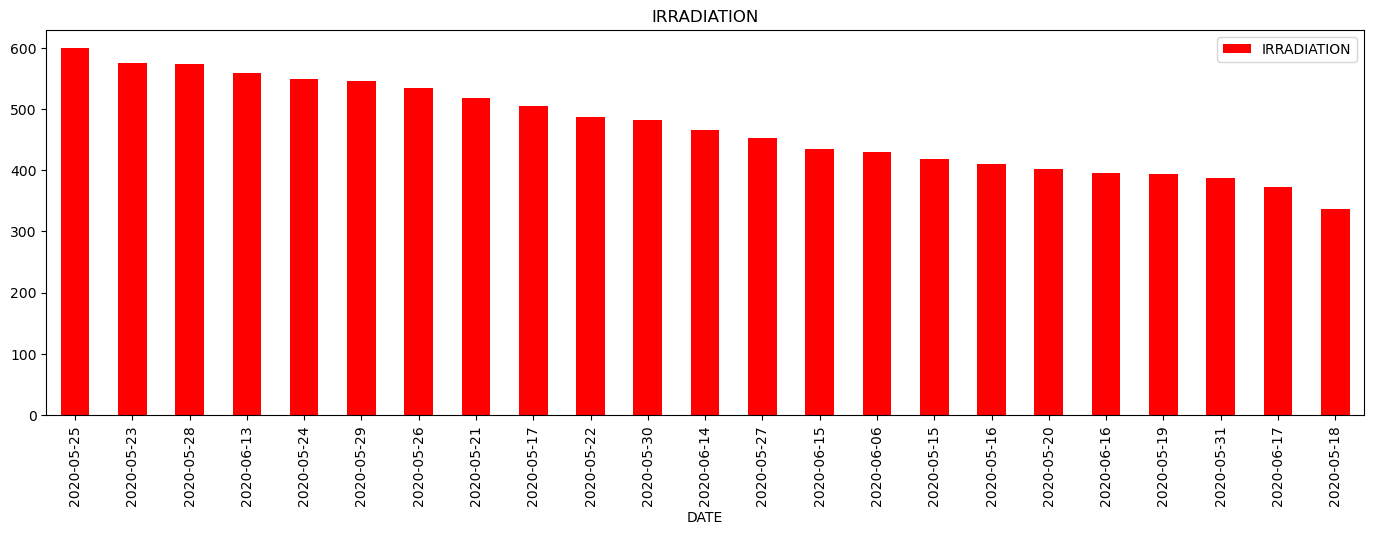

In [49]:
daily_irradiation = power_df.groupby('DATE')['IRRADIATION'].agg('sum')

daily_irradiation.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='red')
plt.title('IRRADIATION')
plt.show()

Highest irradation on 2020-05-25

Lowest irradation on 2020-05-18

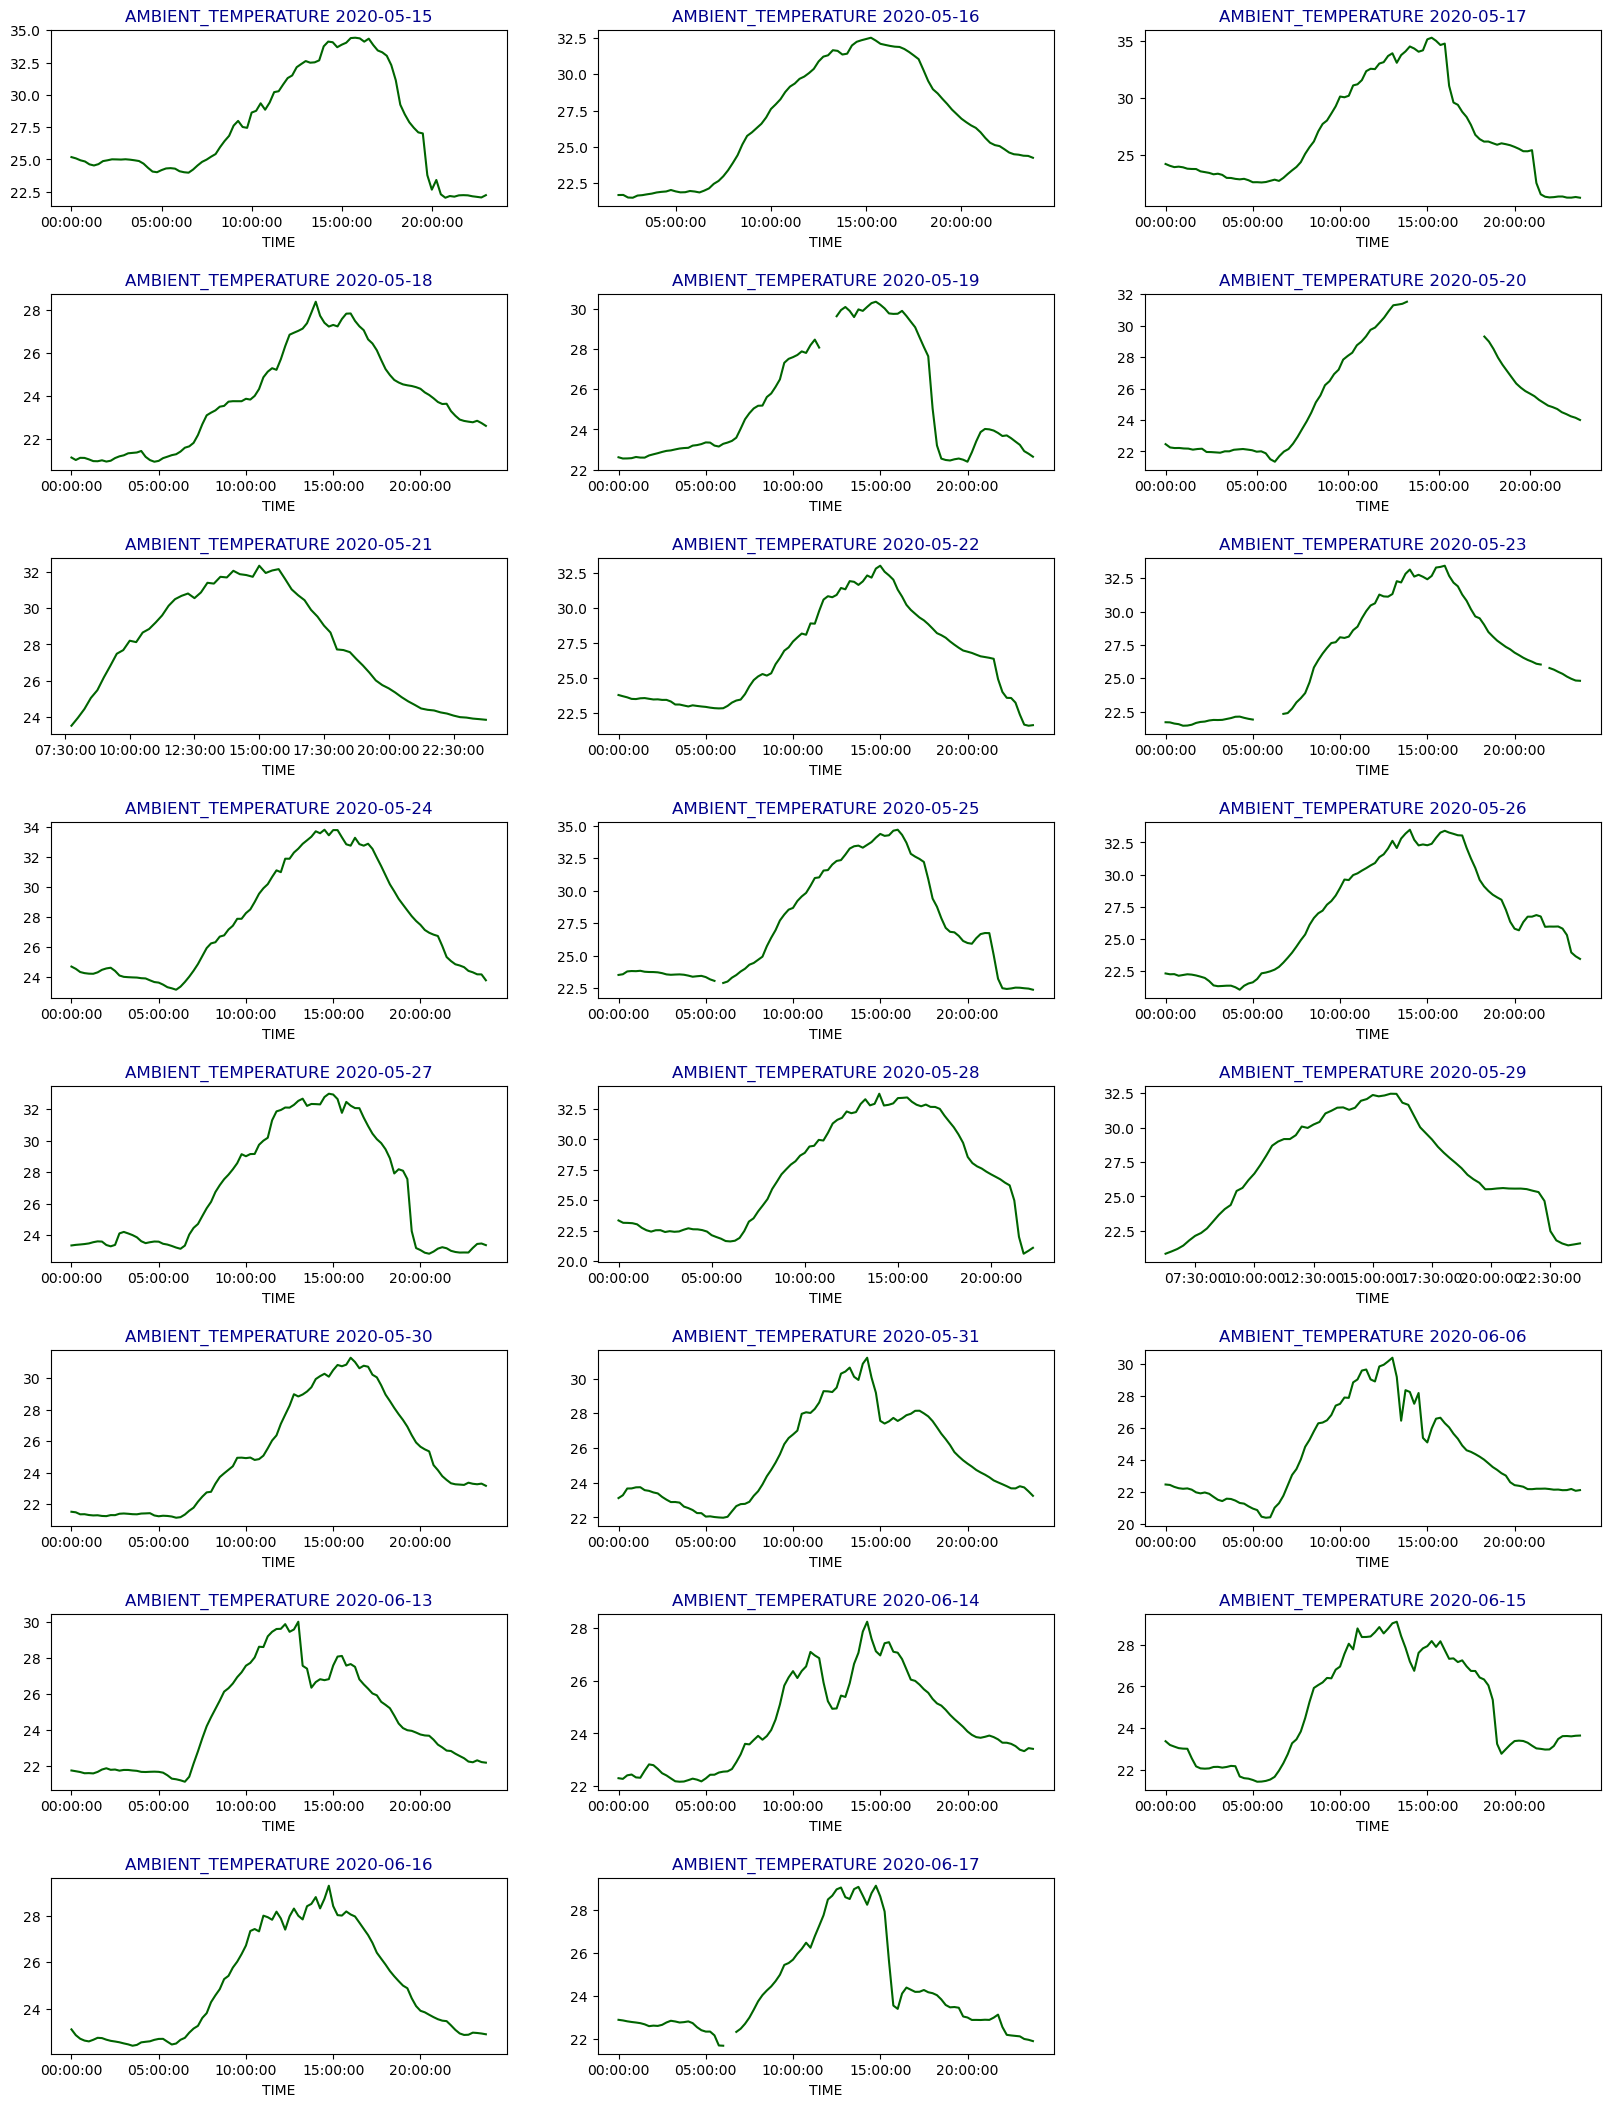

In [50]:
solar_ambiant_temp = power_df.pivot_table(values='AMBIENT_TEMPERATURE', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='AMBIENT_TEMPERATURE'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40)) 
    
    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='darkgreen')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='darkblue')
        
Daywise_plot(data=solar_ambiant_temp, row=12, col=3)

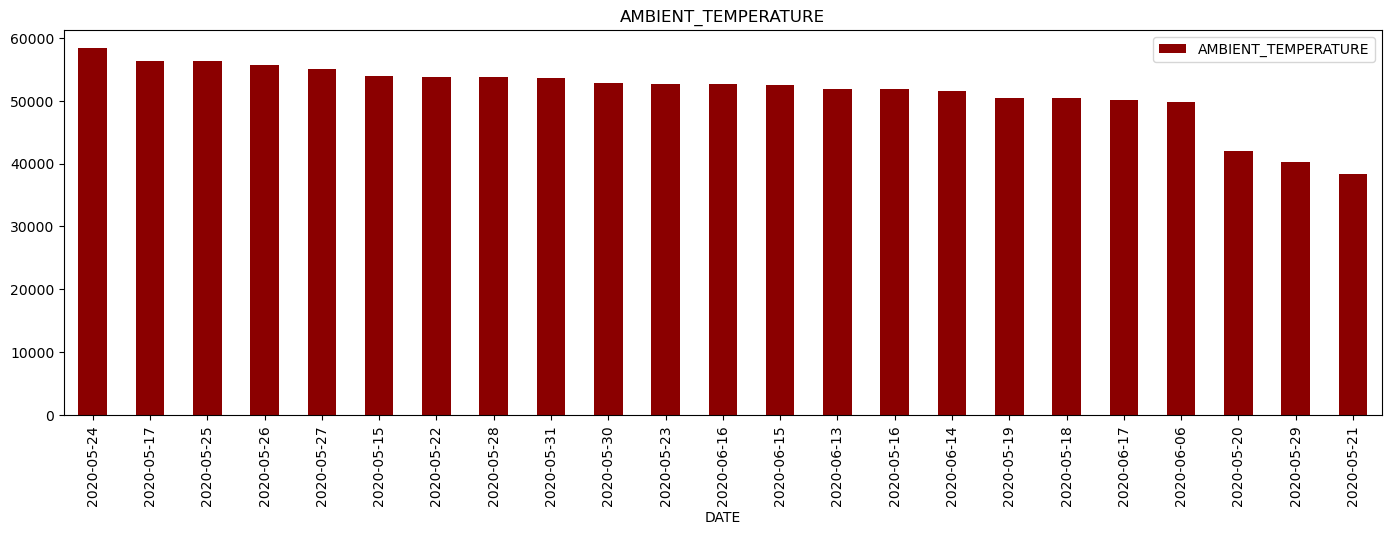

In [51]:
daily_ambient_temp = power_df.groupby('DATE')['AMBIENT_TEMPERATURE'].agg('sum')

daily_ambient_temp.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='darkred')
plt.title('AMBIENT_TEMPERATURE')
plt.show()

### Solar Power Plant Efficiency 

In [21]:
solar_dc = power_df[power_df['DC_POWER'] > 0]['DC_POWER'].values
solar_ac = power_df[power_df['AC_POWER'] > 0]['AC_POWER'].values

In [23]:
solar_dc.max()
solar_ac.max()

1410.95

In [27]:
solar_eff = (np.max(solar_ac)/np.max(solar_dc))*100
print(f"The efficiency of solar power : {solar_eff:0.3f}%")

The efficiency of solar power : 9.750%


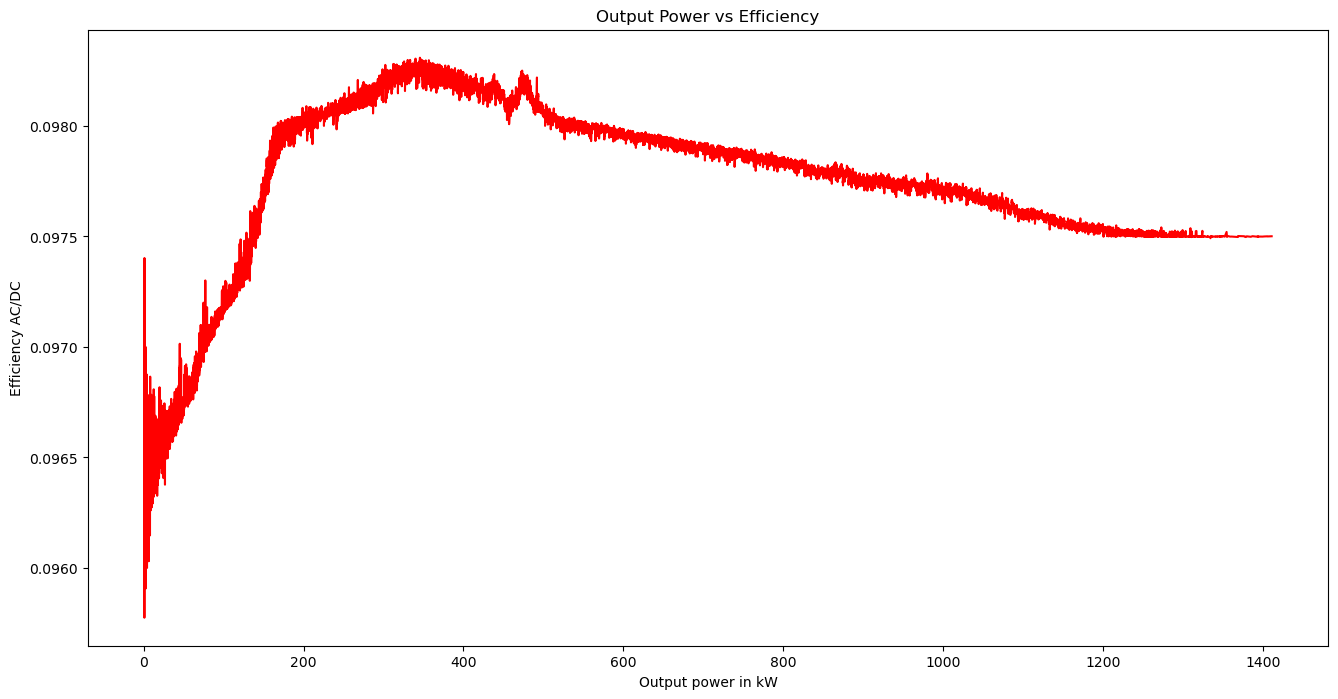

In [28]:
AC_list=[]
for i in power_df['AC_POWER']:
    if i>0:
        AC_list.append(i)
AC_list
#AC_list.sort()
#AC_list.reverse()
len(AC_list)

DC_list=[]
for i in power_df['DC_POWER']:
    if i>0:
        DC_list.append(i)
DC_list
DC_list.sort()
DC_list.reverse()
len(DC_list)

plt.figure(figsize=(16,8))
AC_list.sort()
DC_list.sort()
eff = [i/j for i,j in zip(AC_list,DC_list)]

plt.plot(AC_list,eff,color='red')
plt.xlabel('Output power in kW')
plt.ylabel('Efficiency AC/DC')
plt.title('Output Power vs Efficiency');

## 3. DATA PRE-PROCESSING


In [29]:

X =power_df[['DAILY_YIELD', 'TOTAL_YIELD','AMBIENT_TEMPERATURE', 'IRRADIATION']]
y = power_df['AC_POWER']

train test split

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True, test_size=0.2,random_state=42)

### Model Development

In [39]:


lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)
R2_Score_lr = round(r2_score(y_pred_lr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_lr,"%")


R2 Score :  98.33 %


In [40]:
ls= Lasso()
ls.fit(X_train,y_train)
y_pred_ls = ls.predict(X_test)
R2_Score_ls = round(r2_score(y_pred_ls,y_test) * 100, 2)

print("R2 Score : ",R2_Score_ls,"%")


R2 Score :  98.29 %


In [41]:

dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

y_pred_dtr = lr.predict(X_test)
R2_Score_dtr = round(r2_score(y_pred_dtr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_dtr,"%")

R2 Score :  98.33 %


From the result of three model for prediction, linear regression and decision tree regressor are have a highest R2 score which is 98.33%. Hence, can choose either linear regression or decision tree regressor for forecasting

In [57]:
forecast_model = dtr.predict(X_test)
print(forecast_model)

[116.1125      0.        903.0571429 ... 741.7142857 108.2
   0.       ]


In [58]:
cross_check = pd.DataFrame({'Actual' : y_test , 'Predicted' : forecast_model})
cross_check.head()

,Actual,Predicted
29503,116.4750,116.112500
45488,0.0000,0.000000
40219,868.7125,903.057143
7270,485.1625,478.387500
15418,0.0000,0.000000


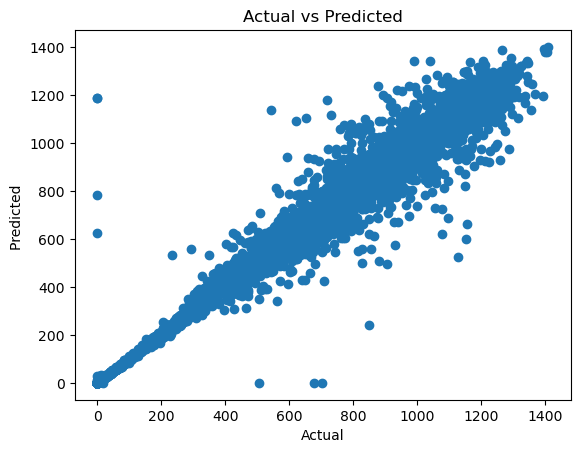

In [59]:
# Visualizing the differences between actual and predicted values
plt.scatter(y_test,forecast_model)
plt.xlabel("Actual")
plt.ylabel("Predicted ")
plt.title("Actual vs Predicted")
plt.show()